In [60]:
#!pip install kneed
import pandas as pd
import sklearn
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
#from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from kneed import KneeLocator
import scipy.stats as stats


In [49]:
NTS_dummy = pd.read_csv('/content/drive/MyDrive/socio_pred/UKDA-5340-tab/NTS_v2.csv')
NTS_dummy.shape

(2445, 137)

In [50]:
# replace NA with zero
#na occurs for std of users with one trip, or count of users with no weekend trip
NTS_dummy = NTS_dummy.fillna(0)

In [52]:
mobility = NTS_dummy.iloc[:,38:]
socio = NTS_dummy.drop(columns = ['IndividualID','SurveyYear']).iloc[:,0:36]

In [102]:
socio_cols = {'age' : socio.columns[0:6],
'sex' : socio.columns[6:8],
'marital' : socio.columns[8:10],
'income': socio.columns[10:13],
'work': socio.columns[13:16],
'hhincome': socio.columns[16:19],
'hh_struc': socio.columns[19:25],
'hh_work': socio.columns[25:28],
'hh_socialclass': socio.columns[28:34],
'urban_rural': socio.columns[34:36]}

## K-means Clustering

In [95]:
#normalize
x = mobility
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
#pca
#keep 85% of variance explained by selected components
pca = PCA(n_components=0.85)
principalComponents = pca.fit_transform(x)
pca.n_components_
#11 components are selected

11

For n_clusters = 2 The average silhouette_score is : 0.2012534938262388
For n_clusters = 3 The average silhouette_score is : 0.20388800922488792
For n_clusters = 4 The average silhouette_score is : 0.1664099587907127
For n_clusters = 5 The average silhouette_score is : 0.16038689969555875
For n_clusters = 6 The average silhouette_score is : 0.1576801177436541
For n_clusters = 7 The average silhouette_score is : 0.16094201563606192
For n_clusters = 8 The average silhouette_score is : 0.16445753190197696
For n_clusters = 9 The average silhouette_score is : 0.15233916960553726
For n_clusters = 10 The average silhouette_score is : 0.15893565593148543
For n_clusters = 11 The average silhouette_score is : 0.15871451476835371
For n_clusters = 12 The average silhouette_score is : 0.15370629962708243
For n_clusters = 13 The average silhouette_score is : 0.15675248027921537
For n_clusters = 14 The average silhouette_score is : 0.1545609381645003
For n_clusters = 15 The average silhouette_score i

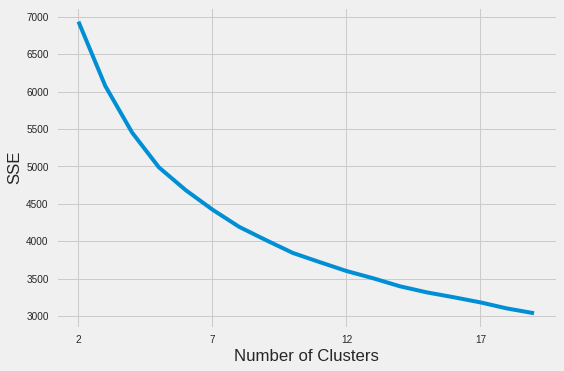

Number of clusters is: 8


In [96]:
# number of clusters
 
def elbow(pcs):

  kmeans_kwargs = {
      "init": "random",
      "n_init": 10,
      "max_iter": 300,
      "random_state": 42,
  }

  # A list holds the SSE values for each k
  sse = []
  #fig, ax = plt.subplots(10, 2, figsize=(15,16))

  max_cluster = min(20,df.shape[0])
  for k in range(2, max_cluster):
      kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
      kmeans.fit(pcs)
      cluster_labels = kmeans.fit_predict(pcs)
      silhouette_avg = silhouette_score(pcs, cluster_labels)
      print(
        "For n_clusters =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
      sse.append(kmeans.inertia_)
      # q, mod = divmod(k, 2)
      # '''
      # Create SilhouetteVisualizer instance with KMeans instance
      # Fit the visualizer
      # '''
      # visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
      # visualizer.fit(features)

  plt.style.use("fivethirtyeight")
  plt.plot(range(2, max_cluster), sse)
  plt.xticks(range(2, max_cluster,5))
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")
  plt.show()

  kl = KneeLocator(
    range(2, max_cluster), sse, curve="convex", direction="decreasing"
  )
  print('Number of clusters is:',  kl.elbow)
  return 

elbow(principalComponents)

In [97]:
#kmeans function
def kplot(pcs,k):

  kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
  }

  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(pcs)
  cluster_labels = kmeans.fit_predict(pcs)
  df = pd.DataFrame(pcs)
  df['label'] = kmeans.labels_
  
  return df

In [100]:
pc_df = kplot(principalComponents,8)

In [101]:
pc_df.groupby('label').size()

label
0    494
1    245
2     94
3    111
4    267
5    266
6    368
7    600
dtype: int64

In [104]:
socio['label'] = pc_df['label']

## Statistical Test for clusters


In [106]:
def chi2stat(df,var):
  df = df.groupby('label').sum()[var]
  #for chi2 test, min freq should be at least 5
  var2 = (df>4).all()[(df>4).all()==True].index 
  
  chi2 = stats.chi2_contingency(df[var2])
  if len(var2)<2:
    print('Not enough data')
  print('P_value: ',chi2[1])
  return


In [107]:
vars = socio_cols.keys()

for v in vars:
  print(v)
  chi2stat(socio,socio_cols[v])
  print('-----')
  

age
P_value:  6.707624333679453e-41
-----
sex
P_value:  1.4287815812030284e-13
-----
marital
P_value:  0.0004611581068161544
-----
income
P_value:  1.1097609660102015e-30
-----
work
P_value:  8.870883361020928e-73
-----
hhincome
P_value:  2.1880000401390716e-29
-----
hh_struc
P_value:  1.5581408881419442e-12
-----
hh_work
P_value:  1.0140532068590497e-47
-----
hh_socialclass
P_value:  2.986022716419507e-47
-----
urban_rural
P_value:  0.014864434516538605
-----


All sociodemographic variables are significantly different among clusters

In [39]:
#mobility.corr().style.background_gradient(cmap='coolwarm')